In [28]:
import sys
import datetime
import time
import os
import pickle
import random
from functools import partial

import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import imageio

import torch
import torch.nn as nn
import torch.nn.functional as tnnf
from torch.utils.data import DataLoader, TensorDataset, Dataset

# need patched version
from t3nsor import TTLinear

In [3]:
device = torch.device("cuda:0")

In [4]:
def set_random_seeds(seed_value, device=device):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5.
    No. Actually for me source is Seminar 12.'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
SEED=555
set_random_seeds(seed_value=SEED)

In [6]:
from IPython.display import HTML, display
import imageio
from base64 import b64encode

def show_video(array, fps=25):
    height = array.shape[1]
    width = array.shape[2]
    
    scaling_coefficient = 320 / max(height, width)
    if scaling_coefficient > 1:
        height *= scaling_coefficient
        width *= scaling_coefficient
        
    array = array.astype(np.uint8)
    mp4_as_bytes = imageio.mimwrite(
        imageio.RETURN_BYTES, array, format="mp4", fps=fps
    )
    b64_encoded = b64encode(mp4_as_bytes)
    display(HTML("""
    <video width="{}" height="{}" controls>
      <source type="video/mp4" src="data:video/mp4;base64,{}">
    </video>
    """.format(width, height, b64_encoded.decode("utf-8"), )
    ))

In [7]:
def show_video_from_disk(filename, fps=25):
    array = np.array(imageio.mimread(filename))
    show_video(array)

In [8]:
HOW_FAST = "fast" # "slow" or "medium" or "fast"
LONG_SEQ = False

RESIZING_SIZE = {
    "slow": (160, 120),
    "medium": (80, 60),
    "fast": (29, 13)
}[HOW_FAST]

GLOBAL_MAX_LEN = 350 if LONG_SEQ else 85

In [9]:
def load_video(filename, resizing_size):
    resized_frames = (
        np.array(Image.fromarray(frame).resize(resizing_size, resample=Image.BICUBIC))
        for frame in imageio.mimread(filename, "ffmpeg")
    )
    
    return np.array(list(resized_frames))

In [10]:
def load_data_v2(full_paths, resizing_size, maxlen):
    X = np.zeros((len(full_paths), maxlen, np.product(resizing_size) * 3), dtype=np.int8)
    for (n, path) in enumerate(tqdm(full_paths)):
        this_clip = load_video(path, resizing_size)
        this_clip = this_clip.reshape(this_clip.shape[0], -1).astype(np.int8)
        this_clip = (this_clip - 128)
        X[n] = pad_sequences([this_clip], maxlen=maxlen, truncating="post", dtype=np.int8)[0]
    return X

In [11]:
data_path = '/mnt/hdd_1tb/datasets/youtube_celebrities_face_data/ytcelebrity/'
SAVE_DIR = "/mnt/hdd_1tb/datasets/youtube_celebrities_face_data/models"

In [12]:
files = os.listdir(data_path)
random.shuffle(files)

In [13]:
targets = [''] * len(files)
for l in range(len(files)):
    # l = 0
    this_file = files[l]
    
    # files are named like 
    this_file_split = this_file.split('_')
    
    # remove .avi or .whatever extension
    this_file_split[-1] = this_file_split[-1].split('.')[0]
    
    # set targets (labels) to strings like "vladimir_putin"
    targets[l] = this_file_split[-2] + '_' + this_file_split[-1]

targets = np.array(targets)

# np.array of unique target labels
classes = np.unique(targets)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(targets)

In [14]:
NUM_TRAIN, NUM_TEST = {
    "fast": (32, 16),
    "medium": (len(files) - 200, 200),
    "slow": (len(files) - 200, 200)
}[HOW_FAST]

N = NUM_TRAIN + NUM_TEST

files = files[:N]
targets = targets[:N]
y = y[:N]

In [15]:
full_paths = np.array([data_path + this_file for this_file in files])

In [16]:
DATASET_SAVE_PATH = os.path.join(SAVE_DIR, f"Xy_seed_{SEED}_{HOW_FAST}.npy")

if os.path.exists(DATASET_SAVE_PATH):
    X = np.load(DATASET_SAVE_PATH, allow_pickle=False)
else:
    X = load_data_v2(full_paths, resizing_size=RESIZING_SIZE, maxlen=GLOBAL_MAX_LEN)
    np.save(DATASET_SAVE_PATH, X, allow_pickle=False)

100%|██████████| 1910/1910 [07:43<00:00,  2.82it/s]


In [17]:
X_train = X[:NUM_TRAIN]
X_test = X[NUM_TRAIN:]

y_train = y[:NUM_TRAIN]
y_test = y[NUM_TRAIN:]

full_paths_train = full_paths[:NUM_TRAIN]
full_paths_test = full_paths[NUM_TRAIN:]

In [18]:
num_features = np.product(RESIZING_SIZE) * 3
num_labels = len(classes)

In [19]:
def show_random_sequence(what, with_original=True):
    if what == "train":
        X = X_train
        y = y_train
        full_paths = full_paths_train
    elif what == "test":
        X = X_test
        y = y_test
        full_paths = full_paths_test
    else:
        raise ValueError("what must be train or test")
        
    index = random.randint(0, len(X)-1)
    label_number = y[index]
    label_name = label_encoder.inverse_transform([label_number])
    print(label_name)
    path = full_paths[index]
    print(path)
    x = X[index].reshape(GLOBAL_MAX_LEN, RESIZING_SIZE[1], RESIZING_SIZE[0], 3) + 128
    show_video(x)
    show_video_from_disk(os.path.join(data_path, path))

In [50]:
show_random_sequence("train")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (80, 60) to (80, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


['jennifer_aniston']
/mnt/hdd_1tb/datasets/youtube_celebrities_face_data/ytcelebrity/0908_02_005_jennifer_aniston.avi


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (320, 262) to (320, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
# show_random_sequence("test")

In [41]:
class GRU(nn.Module):
    def __init__(
        self, in_features, out_features, sequence_length, hidden_state_length,
        linear_layer_maker, dropout_prob
    ):
        super().__init__()
        self.hidden_state_length = hidden_state_length
        self.sequence_length = sequence_length
        
        #initialize components required for calculating $ d^{(t)} $
        #i.e. updated hidden value, which gets elementwisely multiplied by (1 - u{(t-1)})
        # where u is update gate
        # remark: hidden state is h^{(t)},
        # updated hidden value is d^{(t)}
        self.input_to_updated_hidden_value = linear_layer_maker(
            in_features, hidden_state_length, bias=True
        )
        self.hidden_state_to_updated_hidden_value = nn.Linear(
            hidden_state_length, hidden_state_length, bias=False
        )
        self.reset_gate = None
        self.updated_hidden_value_dropout = nn.Dropout(p=dropout_prob)
        
        # initialize components required for calculating $ h^{(t)}, i.e.
        # hidden state
        # here u^{(t-1)} is update gate which, if takes value one,
        # means that new value of h should just equal prev value of h`
        self.hidden_state = None
        self.update_gate = None
        
        # initialize components for calculating update gate
        self.input_to_update_gate = linear_layer_maker(
            in_features, hidden_state_length, bias=True
        )
        self.hidden_state_to_update_gate = nn.Linear(
            hidden_state_length, hidden_state_length, bias=False
        )
        
        # initialize components for calculating reset gate
        self.input_to_reset_gate = linear_layer_maker(
            in_features, hidden_state_length, bias=True
        )
        self.hidden_state_to_reset_gate = nn.Linear(
            hidden_state_length, hidden_state_length, bias=False
        )
        
        # initialize the classifier which performs classification
        # of last hidden state
        self.last_state_to_output = nn.Linear(hidden_state_length, out_features, bias=True)
    
    def forward(self, X):
        assert len(X.shape) == 3
        num_samples = X.shape[0]
        assert X.shape[1] == self.sequence_length
        
        self.hidden_state, self.reset_gate, self.update_gate = [
            torch.zeros(num_samples, self.hidden_state_length, device=X.device)
            for i in range(3)
        ]
        
        for part_index in range(self.sequence_length):
            X_part = X[:, part_index].contiguous()
            
            # this is also called d^{(t)}
            updated_hidden_state_value = self.updated_hidden_value_dropout(torch.tanh(
                self.input_to_updated_hidden_value(X_part)
                + self.hidden_state_to_updated_hidden_value(self.hidden_state * self.reset_gate)
            ))
            
            # calculate hidden state h^{(t)}
            self.hidden_state = self.update_gate * self.hidden_state \
                + (1 - self.update_gate) * updated_hidden_state_value
            
            # calculate update gate u^{(t)} which will affect the next iteration
            self.update_gate = torch.sigmoid(
                self.input_to_update_gate(X_part)
                + self.hidden_state_to_update_gate(self.hidden_state)
            )
            
            # calculate reset gate r^{(t)} which will affect the next iteration
            self.reset_gate = torch.sigmoid(
                self.input_to_reset_gate(X_part)
                + self.hidden_state_to_reset_gate(self.hidden_state)
            )
        
        # we have calculated the last hidden state
        # now we calculate logits
        return self.last_state_to_output(self.hidden_state)

In [21]:
class BuiltinGRU(nn.Module):
    def __init__(self, in_features, out_features, hidden_state_length):
        super().__init__()
        self.hidden_state_length = hidden_state_length
        self.gru = nn.GRU(in_features, hidden_state_length, batch_first=True)
        self.linear = nn.Linear(hidden_state_length, out_features)

    def forward(self, X):
        gru_last_hidden = self.gru(X)[0][:, -1]
        return self.linear(gru_last_hidden)

In [22]:
class NumpyArrayDataset(Dataset):
    def __init__(self, *arrays):
        self.arrays = arrays
    
    def __len__(self):
        return len(self.arrays[0])
    
    def __getitem__(self, idx):
        return tuple(
            torch.from_numpy(array[idx].astype(np.float32)) if len(array[idx].shape) != 0 else torch.tensor(array[idx])
            for array in self.arrays
        )

In [23]:
# dataset_train = TensorDataset(X_train, y_train)
# dataset_test = TensorDataset(X_test, y_test)
dataset_train = NumpyArrayDataset(X_train, y_train)
dataset_test = NumpyArrayDataset(X_test, y_test)

In [35]:
BATCH_SIZE = {"fast": 32, "medium": 32, "slow": 8}[HOW_FAST]

train_loader = DataLoader(
    dataset_train, batch_size=min(BATCH_SIZE, NUM_TRAIN), shuffle=True, drop_last=True,
    num_workers=1, pin_memory=True
)
val_loader = DataLoader(
    dataset_test, batch_size=min(BATCH_SIZE, NUM_TEST), shuffle=True, drop_last=False,
    num_workers=1, pin_memory=True
)

In [36]:
class TrainingHistory(object):
    """History of how {train,test} {loss,accuracy} changes as training goes."""
    def __init__(self):
        self.epochs = []
        self.train_losses = []
        self.train_accuracies = []
        self.validation_losses = []
        self.validation_accuracies = []
    
    def show_plots(self, clear):
        if clear:
            clear_output(wait=True)
        fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
        axes = axes.flatten()
        
        axes[0].set_title("Loss")
        axes[0].plot(self.epochs, self.train_losses, label="train loss")
        axes[0].plot(self.epochs, self.validation_losses, label="validation loss")
        axes[0].legend()
        
        axes[1].set_title(
            "Accuracy. Last val: {}, best val: {}".format(
                self.validation_accuracies[-1],
                max(self.validation_accuracies)
            )
        )
        axes[1].plot(self.epochs, self.train_accuracies, label="train accuracy")
        axes[1].plot(
            self.epochs, self.validation_accuracies,
            label="validation accuracy"
        )
        axes[1].legend()
        
        plt.show()

In [37]:
from ignite.engine import (
    create_supervised_evaluator, create_supervised_trainer,
    Events
)
from ignite.metrics import Accuracy, Loss
from ignite.handlers import EarlyStopping, ModelCheckpoint
import functools
from IPython.display import clear_output
import pickle

def do_every_num_epochs(num_epochs):
    """This must be written after @trainer.on, not before. Run function
    every few epochs instead of every epoch."""
    def decorate(func):
        def decorated(engine, *args, **kwargs):
            if engine.state.epoch % num_epochs == 0:
                return func(engine, *args, **kwargs)
        return functools.update_wrapper(decorated, func)
    return decorate
                      
def train_and_evaluate(
    model, optimizer,
    eval_every_num_epochs, plot_every_num_epochs,
    num_epochs, early_stopping_epochs,
    save_dir, save_prefix
):
    """The main neural network training function. Trains a nn,
    evaluates it as it goes. Saves the best model in save_dir.
    The filename will have prefix save_prefix. Performs training
    for at most num_epochs. If validation accuracy doesn't improve for
    early_stopping_epochs, stops training process. Plots training
    history during training.
    
    eval_every_num_epochs - how often to evaluate.
    
    plot_every_num_epochs - how often to update plots."""
    trainer = create_supervised_trainer(
        model=model, optimizer=optimizer,
        loss_fn=criterion, device=device
    )
    
    evaluator = create_supervised_evaluator(
        model,
        metrics={
            "accuracy": Accuracy(),
            "loss": Loss(criterion)
        },
        device=device
    )
    
    history = TrainingHistory()
    
    def evaluate(loader, loss_log, accuracy_log):
        model.train(False)
        evaluator.run(loader)
        loss_log.append(evaluator.state.metrics["loss"])
        accuracy_log.append(evaluator.state.metrics["accuracy"])

    @trainer.on(Events.EPOCH_COMPLETED)
    @do_every_num_epochs(eval_every_num_epochs)
    def evaluate_on_train_and_test(engine):
        evaluate(train_loader, history.train_losses, history.train_accuracies)
        evaluate(val_loader, history.validation_losses, history.validation_accuracies)
        assert not isinstance(engine.state.epoch, torch.Tensor)
        history.epochs.append(engine.state.epoch)
    
    @trainer.on(Events.EPOCH_COMPLETED)
    @do_every_num_epochs(plot_every_num_epochs)
    def update_plot(*args):
        history.show_plots(clear=True)
    
    trainer.add_event_handler(Events.EPOCH_COMPLETED, EarlyStopping(
        patience=early_stopping_epochs, # wait this many epochs before stopping
        score_function=lambda engine: history.validation_accuracies[-1],
        trainer=trainer
    ))
    
    # Add handler which saves model to disk whenever it achieves
    # new best result
    trainer.add_event_handler(
        Events.EPOCH_COMPLETED,
        ModelCheckpoint(
            save_dir, save_prefix,
            score_function=lambda engine: history.validation_accuracies[-1],
            n_saved=1, atomic=True, require_empty=False,
            save_as_state_dict=True
        ),
        {"model": model} # what should be saved
    )
        
    trainer.run(train_loader, max_epochs=num_epochs)
    
    # save training history to disk as well
    with open(os.path.join(save_dir, f"{save_prefix}_history.pkl"), "wb") as history_f:
        pickle.dump(history, history_f)
    
    # usually we will not be using return values, because it returns
    # last model, not the best model
    return (
        model,
        history
    )

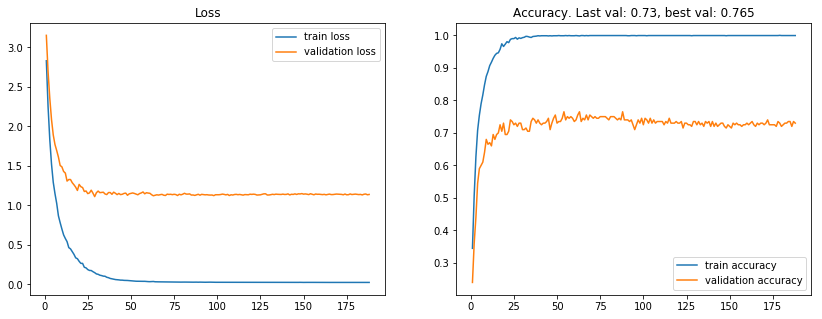

In [40]:
# model = GRU(
#     num_features, num_labels,
#     sequence_length=GLOBAL_MAX_LEN,
#     hidden_state_length=256,
#     linear_layer_maker=partial(TTLinear, d=4, tt_rank=4)
# ).to(device)
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=1e-3, weight_decay=1e-3, amsgrad=True
# )
# criterion = tnnf.cross_entropy
# train_and_evaluate(
#     model,
#     optimizer,
#     eval_every_num_epochs=1,
#     plot_every_num_epochs=1,
#     num_epochs=1000,
#     early_stopping_epochs=30,
#     save_dir=SAVE_DIR,
#     save_prefix=f"tt_gru_adam_seed_{SEED}_{HOW_FAST}"
# )
# pass

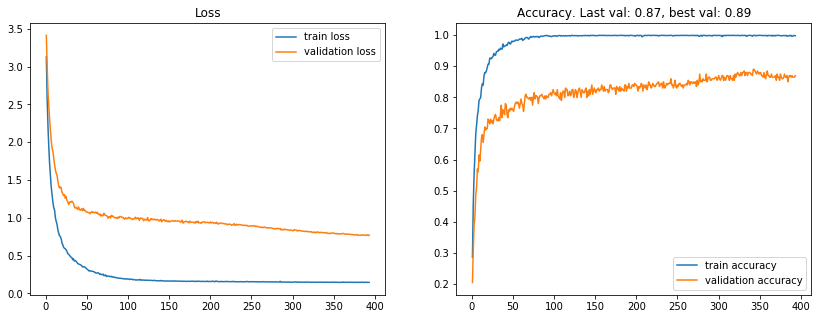

In [44]:
dropout_prob = 0.4
tt_rank = 3
model = GRU(
    num_features, num_labels,
    sequence_length=GLOBAL_MAX_LEN,
    hidden_state_length=256,
    linear_layer_maker=partial(TTLinear, d=4, tt_rank=tt_rank),
    dropout_prob=dropout_prob
).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3, weight_decay=1e-2, amsgrad=True
)
criterion = tnnf.cross_entropy
train_and_evaluate(
    model,
    optimizer,
    eval_every_num_epochs=1,
    plot_every_num_epochs=1,
    num_epochs=400,
    early_stopping_epochs=50,
    save_dir=SAVE_DIR,
    save_prefix=f"tt_gru_adam_seed_{SEED}_{HOW_FAST}_dropout_prob_{dropout_prob}_rank_{tt_rank}"
)
pass

In [ ]:
# import gc;
# gc.collect()
# torch.cuda.empty_cache()

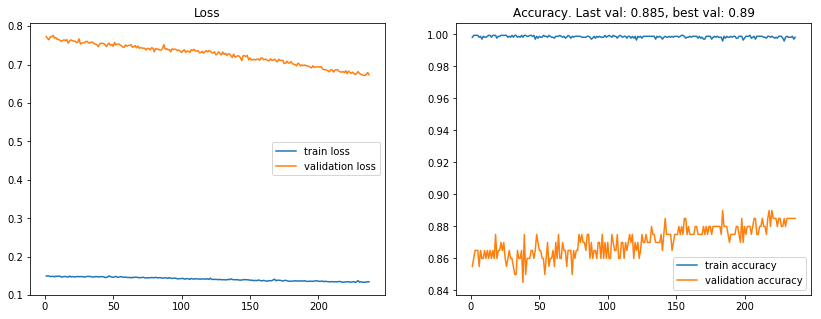

In [ ]:
# I want to continue training, maybe something will come out of it
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3 * 1e-4, weight_decay=1e-2, amsgrad=True
)
train_and_evaluate(
    model,
    optimizer,
    eval_every_num_epochs=1,
    plot_every_num_epochs=1,
    num_epochs=500,
    early_stopping_epochs=500,
    save_dir=SAVE_DIR,
    save_prefix=f"tt_gru_adam_seed_{SEED}_{HOW_FAST}_dropout_prob_{dropout_prob}_rank_{tt_rank}_continued"
)